# Multivariate Time Series Regression

### Loading Libraries

In [55]:
# Numerical Computing
import numpy as np

# Data Manipulation
import pandas as pd
import pandas_datareader.data as web

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Warning
import warnings

# Path
from pathlib import Path

# Scikit-Learn
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import minmax_scale
from sklearn.metrics import mean_absolute_error

# TensorFlow
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [12]:
np.random.seed(42)

idx = pd.IndexSlice

sns.set_style('whitegrid')

In [13]:
%matplotlib inline

In [17]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')

if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using GPU


In [21]:
results_path = Path('results', 'multivariate_time_series')

if not results_path.exists():
    results_path.mkdir(parents=True)

### Loading Data

In [24]:
df = web.DataReader(['UMCSENT', 'IPGMFN'], 'fred', '1980', '2019-12').dropna()

df.columns = ['sentiment', 'ip']

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 480 entries, 1980-01-01 to 2019-12-01
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sentiment  480 non-null    float64
 1   ip         480 non-null    float64
dtypes: float64(2)
memory usage: 11.2 KB


In [26]:
df.head()

,sentiment,ip
DATE,,
1980-01-01,67.0,45.8562
1980-02-01,66.9,46.9435
1980-03-01,56.5,47.5013
1980-04-01,52.7,46.1175
1980-05-01,51.7,44.7997


### Preparing Data

#### Stationarity

In [49]:
df_transformed = (pd.DataFrame({'ip': np.log(df.ip).diff(12),
                                'sentiment': df.sentiment.diff(12)})
                  .dropna())

#### Scaling

In [57]:
df_transformed = df_transformed.apply(minmax_scale)

#### Plotting Original & Transformed Series

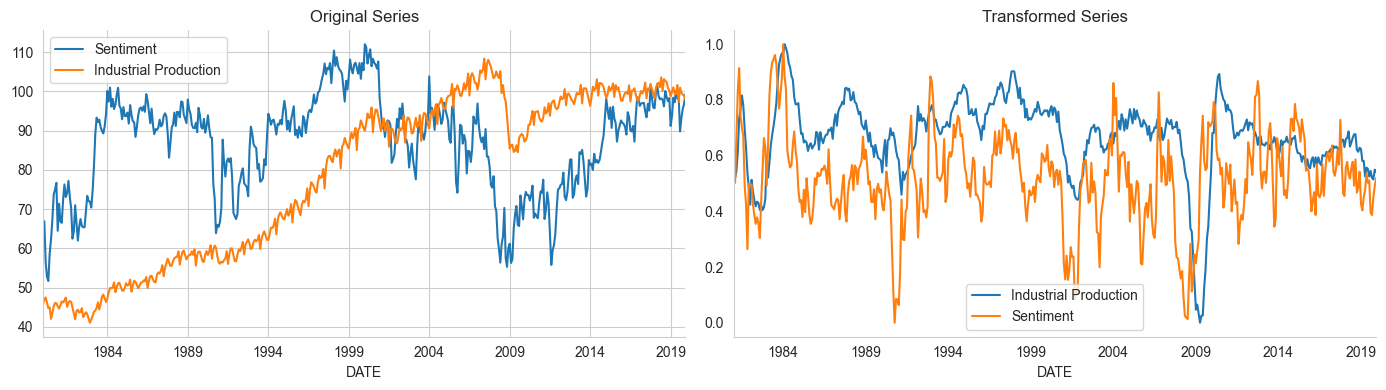

In [60]:
fig, axes = plt.subplots(ncols=2, figsize=(14,4))

columns={'ip': 'Industrial Production', 'sentiment': 'Sentiment'}

df.rename(columns=columns).plot(ax=axes[0], title='Original Series')
df_transformed.rename(columns=columns).plot(ax=axes[1], title='Transformed Series')
sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'multi_rnn', dpi=300)
plt.grid()
plt.show()

#### Reshaping Data into RNN Format

In [63]:
df.values.reshape(-1, 12, 2).shape

(40, 12, 2)

In [65]:
def create_multivariate_rnn_data(data, window_size):
    y = data[window_size:]
    n = data.shape[0]
    X = np.stack([data[i: j] 
                  for i, j in enumerate(range(window_size, n))], axis=0)
    return X, y

In [67]:
window_size = 18

In [69]:
X, y = create_multivariate_rnn_data(df_transformed, window_size=window_size)

In [71]:
X.shape, y.shape

((450, 18, 2), (450, 2))

In [73]:
df_transformed.head()

,ip,sentiment
DATE,,
1981-01-01,0.529737,0.576214
1981-02-01,0.517451,0.502513
1981-03-01,0.545862,0.670017
1981-04-01,0.616060,0.832496
1981-05-01,0.734106,0.914573


In [75]:
test_size =24

train_size = X.shape[0]-test_size

In [77]:
X_train, y_train = X[:train_size], y[:train_size]

X_test, y_test = X[train_size:], y[train_size:]

In [79]:
X_train.shape, X_test.shape

((426, 18, 2), (24, 18, 2))

### Defining Model Architecture

### Defining Model Architecture

In [82]:
K.clear_session()

In [84]:
n_features = output_size = 2

In [98]:
lstm_units = 12

dense_units = 6

In [100]:
rnn = Sequential([
    LSTM(units=lstm_units,
         dropout=.1,
         recurrent_dropout=.1,
         input_shape=(window_size, n_features), name='LSTM',
         return_sequences=False),
    Dense(dense_units, name='FC'),
    Dense(output_size, name='Output')
])

2025-05-04 08:19:15.859777: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Max
2025-05-04 08:19:15.859850: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2025-05-04 08:19:15.859862: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2025-05-04 08:19:15.859906: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-04 08:19:15.859936: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/opt/anaconda3/envs/MLAT/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequenti

In [102]:
rnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ LSTM (LSTM)                     │ (None, 12)             │           720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ FC (Dense)                      │ (None, 6)              │            78 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 2)              │            14 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 812 (3.17 KB)

 Trainable params: 812 (3.17 KB)

 Non-trainable params: 0 (0.00 B)

In [104]:
rnn.compile(loss='mae', optimizer='RMSProp')

### Training Model

In [107]:
lstm_path = (results_path / 'lstm.h5').as_posix()

checkpointer = ModelCheckpoint(filepath=lstm_path,
                               verbose=1,
                               monitor='val_loss',
                               mode='min',
                               save_best_only=True)

In [109]:
early_stopping = EarlyStopping(monitor='val_loss', 
                              patience=10,
                              restore_best_weights=True)

In [111]:
result = rnn.fit(X_train,
                 y_train,
                 epochs=100,
                 batch_size=20,
                 shuffle=False,
                 validation_data=(X_test, y_test),
                 callbacks=[early_stopping, checkpointer],
                 verbose=1)

Epoch 1/100


2025-05-04 08:20:03.248788: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - loss: 0.2610
Epoch 1: val_loss improved from inf to 0.04168, saving model to results/multivariate_time_series/lstm.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 402ms/step - loss: 0.2576 - val_loss: 0.0417
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - loss: 0.1302
Epoch 2: val_loss did not improve from 0.04168
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 333ms/step - loss: 0.1295 - val_loss: 0.0436
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - loss: 0.1141
Epoch 3: val_loss did not improve from 0.04168
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 336ms/step - loss: 0.1140 - val_loss: 0.0430
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - loss: 0.1091
Epoch 4: val_loss did not improve from 0.04168
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 343ms/step - loss: 0.1089 - val_loss: 0.0456
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - loss: 0.1105
Epoch 5: val_loss did not improve from 0.04168
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 342ms/step - loss: 0.1103 - val_loss: 0.0472
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - loss: 0.1071
Epoch 6: val_loss did not improve from 0.04168
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 341ms/step - loss: 

#### Evaluating Results

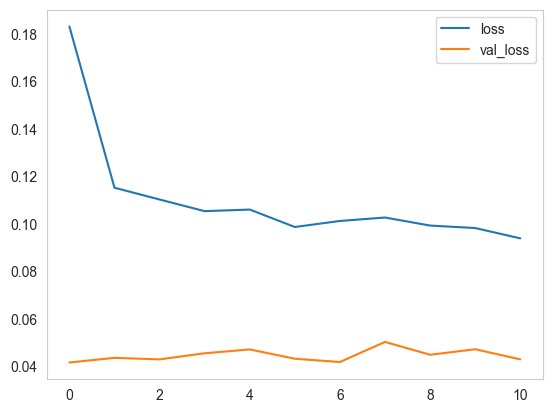

In [137]:
pd.DataFrame(result.history).plot();
plt.grid()
plt.show()

In [139]:
y_pred = pd.DataFrame(rnn.predict(X_test), 
                      columns=y_test.columns, 
                      index=y_test.index)
y_pred.info()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24 entries, 2018-01-01 to 2019-12-01
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ip         24 non-null     float32
 1   sentiment  24 non-null     float32
dtypes: float32(2)
memory usage: 384.0 bytes


In [141]:
test_mae = mean_absolute_error(y_pred, y_test)

In [143]:
print(test_mae)

0.041681876752078836


In [145]:
y_test.index

DatetimeIndex(['2018-01-01', '2018-02-01', '2018-03-01', '2018-04-01',
               '2018-05-01', '2018-06-01', '2018-07-01', '2018-08-01',
               '2018-09-01', '2018-10-01', '2018-11-01', '2018-12-01',
               '2019-01-01', '2019-02-01', '2019-03-01', '2019-04-01',
               '2019-05-01', '2019-06-01', '2019-07-01', '2019-08-01',
               '2019-09-01', '2019-10-01', '2019-11-01', '2019-12-01'],
              dtype='datetime64[ns]', name='DATE', freq=None)

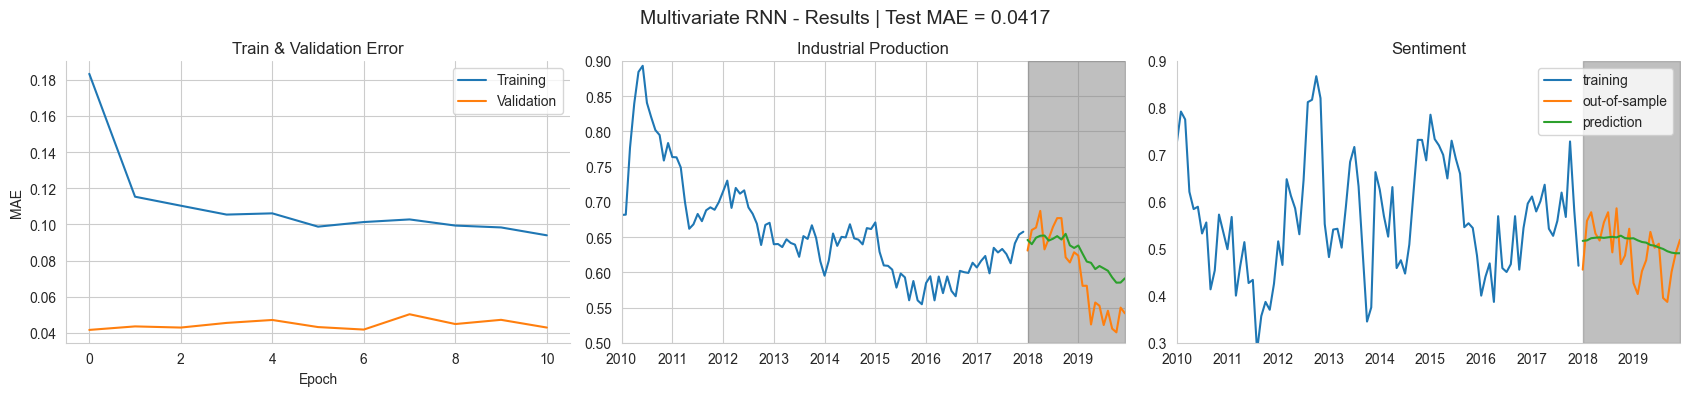

In [147]:
fig, axes = plt.subplots(ncols=3, figsize=(17, 4))

pd.DataFrame(result.history).rename(columns={'loss': 'Training',
                                              'val_loss': 'Validation'}).plot(ax=axes[0], title='Train & Validation Error')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('MAE')
col_dict = {'ip': 'Industrial Production', 'sentiment': 'Sentiment'}

for i, col in enumerate(y_test.columns, 1):
    y_train.loc['2010':, col].plot(ax=axes[i], label='training', title=col_dict[col])
    y_test[col].plot(ax=axes[i], label='out-of-sample')
    y_pred[col].plot(ax=axes[i], label='prediction')
    axes[i].set_xlabel('')

axes[1].set_ylim(.5, .9)
axes[1].fill_between(x=y_test.index, y1=0.5, y2=0.9, color='grey', alpha=.5)

axes[2].set_ylim(.3, .9)
axes[2].fill_between(x=y_test.index, y1=0.3, y2=0.9, color='grey', alpha=.5)

plt.legend()
fig.suptitle('Multivariate RNN - Results | Test MAE = {:.4f}'.format(test_mae), fontsize=14)
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.85)
fig.savefig(results_path / 'multivariate_results', dpi=300);
plt.grid()
plt.show()